In [1]:
import os
import json
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
from collections import Counter
import seaborn as sns
import timm
from torch.optim import Adam
from torchsummary import summary
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
image_dir = "../to anwesh/selected_images"  # Path to the image directory
metadata_path = "../to anwesh/selected_images.txt"  # Path to the metadata JSON file

In [3]:
class OurDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            label_file (str): Path to the file containing labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Load labels from the text file
        self.image_labels = {}
        with open(label_file, 'r') as f:
            for line in f:
                image_name, label = line.strip().split(":")
                label = int(label.strip())
                self.image_labels[image_name] = label

        # List of image filenames
        self.image_files = list(self.image_labels.keys())
    
    def __len__(self):
        """Returns the total number of samples"""
        return len(self.image_files)
    
    def __getitem__(self, idx):
        """Fetch an image and its label"""
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        
        # Get label
        label = self.image_labels[img_name]
        
        # Apply transformation if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((29, 29)),
    transforms.ToTensor()])

In [5]:
dataset = OurDataset(image_dir=image_dir, label_file=metadata_path, transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
def plot_training_history(history):
    """Plot training history including loss and accuracy curves."""
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['test_losses'], label='Test Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['test_accuracies'], label='Test Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the model on the test set and print detailed metrics."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate metrics
    test_acc = accuracy_score(all_targets, all_preds)
    
    print("\nTest Set Evaluation:")
    print(f"Accuracy: {test_acc:.4f}")
    
    return test_acc


In [8]:
class InceptionResNetABlock(nn.Module):
    def __init__(self, in_channels, scale=0.17):
        super(InceptionResNetABlock, self).__init__()
        self.scale = scale
        self.branch0 = nn.Conv2d(in_channels, 32, kernel_size=1, stride=1, padding=0)
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )
        self.conv_up = nn.Conv2d(96, in_channels, kernel_size=1, stride=1, padding=0)
    
    def forward(self, x):
        branch0 = self.branch0(x)
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        mixed = torch.cat([branch0, branch1, branch2], dim=1)
        up = self.conv_up(mixed)
        return F.relu(x + self.scale * up)

# Inception-ResNet Model
class InceptionResNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super(InceptionResNetV1, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.inception_a = InceptionResNetABlock(in_channels=128)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionResNetV1(num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [9]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Track running loss
        running_loss += loss.item()
        
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=False)  # Get the predicted class
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 10_000 == 0:  # Adjust this to suit your dataset size
            accuracy = 100. * correct / total
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.6f} Accuracy: {accuracy:.2f}%")
    
    # Print overall training loss and accuracy for the epoch
    overall_accuracy = 100. * correct / len(train_loader.dataset)
    print(f"Epoch {epoch} Summary: Average Loss: {running_loss / len(train_loader):.6f}, "
          f"Accuracy: {overall_accuracy:.2f}%")


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(target).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_targets), yticklabels=np.unique(all_targets))
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

In [10]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionResNetV1(num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# model.load_state_dict(torch.load("./our_dos_classifier_reduced_inceptionresnet.pth", weights_only=True))

for epoch in range(1, 201):
    train(model, device, train_loader, optimizer, criterion, epoch)

Train Epoch: 1 [0/2230] Loss: 0.686739 Accuracy: 56.25%
Epoch 1 Summary: Average Loss: 0.693923, Accuracy: 50.36%
Train Epoch: 2 [0/2230] Loss: 0.690166 Accuracy: 51.56%
Epoch 2 Summary: Average Loss: 0.687041, Accuracy: 55.07%
Train Epoch: 3 [0/2230] Loss: 0.680443 Accuracy: 70.31%
Epoch 3 Summary: Average Loss: 0.661807, Accuracy: 67.17%
Train Epoch: 4 [0/2230] Loss: 0.609284 Accuracy: 93.75%
Epoch 4 Summary: Average Loss: 0.531855, Accuracy: 86.68%
Train Epoch: 5 [0/2230] Loss: 0.562815 Accuracy: 70.31%
Epoch 5 Summary: Average Loss: 0.378595, Accuracy: 87.62%
Train Epoch: 6 [0/2230] Loss: 0.338793 Accuracy: 90.62%
Epoch 6 Summary: Average Loss: 0.324406, Accuracy: 89.01%
Train Epoch: 7 [0/2230] Loss: 0.440210 Accuracy: 81.25%
Epoch 7 Summary: Average Loss: 0.306494, Accuracy: 89.10%
Train Epoch: 8 [0/2230] Loss: 0.383518 Accuracy: 89.06%
Epoch 8 Summary: Average Loss: 0.307873, Accuracy: 89.24%
Train Epoch: 9 [0/2230] Loss: 0.220806 Accuracy: 93.75%
Epoch 9 Summary: Average Loss: 0


Test set: Average loss: 0.0193, Accuracy: 2520/3001 (83.97%)
Precision: 0.8397, Recall: 0.8397, F1-score: 0.8397



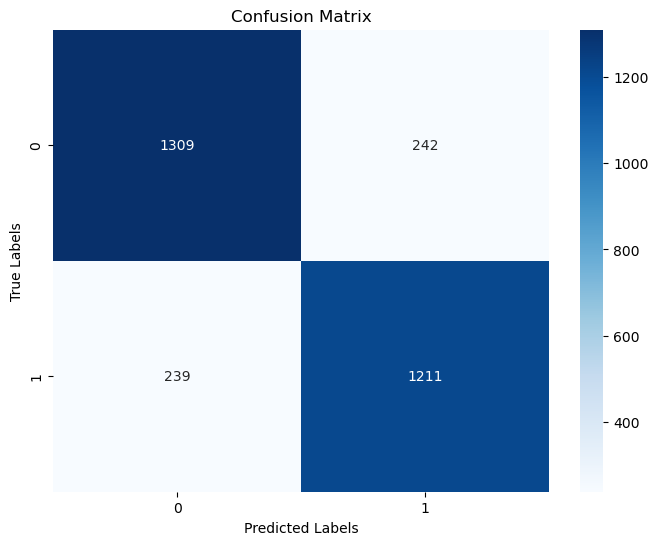

In [21]:
test(model, device, test_loader, criterion)   

In [12]:
torch.save(model.state_dict(), "./our_dos_classifier_reduced_inceptionresnet.pth")

In [13]:
def count_labels_in_subset(dataset):
    label_count = Counter()
    for _, label in dataset:
        label_count[label] += 1  # Directly count the label since it's an int
    return label_count

In [14]:
train_label_count = count_labels_in_subset(train_dataset)
test_label_count = count_labels_in_subset(test_dataset)

# Print the label distribution
print(f"Training set label distribution: {train_label_count}")
print(f"Testing set label distribution: {test_label_count}")

Training set label distribution: Counter({0: 1123, 1: 1107})
Testing set label distribution: Counter({0: 304, 1: 254})


In [15]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    untrainable_params = total_params - trainable_params

    return total_params, trainable_params, untrainable_params

total_params, trainable_params, untrainable_params = count_parameters(model)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Frozen Parameters (Feature Extractor of Reduced Inception Resnet): {untrainable_params}")

Total Parameters: 286498
Trainable Parameters: 286498
Frozen Parameters (Feature Extractor of Reduced Inception Resnet): 0
